# Benchmarks
---

## Line optical depth
--- 

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch

from p3droslo.model import TensorModel
from p3droslo.lines import Line
from astropy        import constants
from time           import time
from ipywidgets     import interact

In [2]:
R = 495000.0
N = 1280

nH2 = 1.0e+12        # [m^-3]
nCO = 1.0e-4 * nH2   # [m^-3]
T   = 45             # [k]
trb = 150.0          # [m/s]
cΔβ = 0.45

model = TensorModel(shape=(N,), sizes=(R,))
model['nCO'        ]  = nCO * np.ones(N)
model['temperature']  = T   * np.ones(N)
model['velocity_z']   = cΔβ * np.linspace(0.0, R, N)
model['v_turbulence'] = trb * np.ones(N)

print('velocity increment =', cΔβ * model.dx(0), 'm/s')

velocity increment = 174.0234375 m/s


In [3]:
line = Line(
    species_name = "test",
    transition   = 0,
    datafile     = "data/test.txt",
    molar_mass   = 1.0
)

You have selected line:
    test(J=-)
Please check the properties that were inferred:
    Frequency         1.798754700e+11  Hz
    Einstein A coeff  1.000000000e-04  1/s
    Molar mass        1.0              g/mol


In [4]:
N_freqs = 100
v_pixel = 5000.0

dd    = (N_freqs-1)/2 * v_pixel/constants.c.si.value
fmin  = line.frequency - line.frequency*dd
fmax  = line.frequency + line.frequency*dd
freqs = torch.linspace(fmin, fmax, N_freqs, dtype=torch.float64)

In [5]:
def get_doppler_shifted_frequencies(v_los, frequencies):
    """
    Doppler shifts frequencies given the velocity along the line of sight.
    """
    # Compute the Doppler shift for each cell
    shift = 1.0 + v_los * (1.0 / constants.c.si.value)

    # Create freqency tensor for each cell
    freqs = torch.einsum("..., f -> ...f", shift, frequencies)
    
    return freqs

In [6]:
nCO    = model['nCO']        
tmp    = model['temperature']
vel    = model['velocity_z']
v_turb = model['v_turbulence']
    
frequencies = get_doppler_shifted_frequencies(vel, freqs)
    
# Compute the LTE line emissivity and opacity, and the line profile
eta, chi = line.LTE_emissivity_and_opacity(nCO, tmp, v_turb, frequencies)

tau_old = torch.empty_like(chi) 
tau_old[...,  0 , :] = 0.0
tau_old[..., +1:, :] = torch.cumsum(chi, dim=0)[..., :-1, :] * model.dx(0)

In [7]:
pop            = line.LTE_pops(temperature=tmp)
eta_ij, chi_ij = line.emissivity_and_opacity_ij(pop=pop)

In [8]:
dtau_new, tau_new = line.optical_depth_along_last_axis(
    chi_ij       = chi_ij,
    density      = nCO,
    temperature  = tmp,
    v_turbulence = v_turb,
    velocity_los = vel,
    frequencies  = freqs,
    dx           = model.dx(0)
)

In [9]:
dtau_new2, tau_new2 = line.optical_depth_along_last_axis2(
    chi_ij       = chi_ij,
    density      = nCO,
    temperature  = tmp,
    v_turbulence = v_turb,
    velocity_los = vel,
    frequencies  = freqs,
    dx           = model.dx(0)
)

In [10]:
import torch.autograd.profiler as profiler

with profiler.profile(with_stack=True, profile_memory=True) as prof:

    dtau_new2, tau_new2 = line.optical_depth_along_last_axis(
        chi_ij       = chi_ij,
        density      = nCO,
        temperature  = tmp,
        v_turbulence = v_turb,
        velocity_los = vel,
        frequencies  = freqs,
        dx           = model.dx(0)
    )

print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=5))

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                aten::nonzero        60.86%      15.985ms        61.31%      16.104ms     392.780us      31.23 Mb      31.23 Mb            41  
                  aten::index        11.05%       2.902ms        63.17%      16.591ms     502.758us      12.69 Mb     -12.69 Mb            33  
                    aten::exp         4.89%       1.284ms         4.89%       1.284ms     428.000us       1.95 Mb       1.95 Mb             3  
                    aten::mul         4.12%       1.083ms         4.12%       1.083ms      33.844us       8.85 Mb       8.85 Mb         

[W CUDAFunctions.cpp:109] Warning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (function operator())
STAGE:2023-07-26 16:16:34 1573613:1573613 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
[W CPUAllocator.cpp:235] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event
STAGE:2023-07-26 16:16:34 1573613:1573613 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-07-26 16:16:34 1573613:1573613 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


In [11]:
import torch.autograd.profiler as profiler

with profiler.profile(with_stack=True, profile_memory=True) as prof:

    dtau_new2, tau_new2 = line.optical_depth_along_last_axis2(
        chi_ij       = chi_ij,
        density      = nCO,
        temperature  = tmp,
        v_turbulence = v_turb,
        velocity_los = vel,
        frequencies  = freqs,
        dx           = model.dx(0)
    )

print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=5))

STAGE:2023-07-26 16:16:34 1573613:1573613 ActivityProfilerController.cpp:311] Completed Stage: Warm Up


RuntimeError: stack.size() INTERNAL ASSERT FAILED at "../torch/csrc/autograd/profiler_python.cpp":963, please report a bug to PyTorch. Python replay stack is empty.

In [12]:
torch.ones(23, dtype=bool)

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True])

In [13]:
%%timeit
tau_old = torch.empty_like(chi) 
tau_old[...,  0 , :] = 0.0
tau_old[..., +1:, :] = torch.cumsum(chi, dim=0)[..., :-1, :] * model.dx(0)

347 µs ± 19 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
%%timeit
dtau_new, tau_new = line.optical_depth_along_last_axis(
    chi_ij       = chi_ij,
    density      = nCO,
    temperature  = tmp,
    v_turbulence = v_turb,
    velocity_los = vel,
    frequencies  = freqs,
    dx           = model.dx(0)
)

8.81 ms ± 371 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%%timeit
dtau_new2, tau_new2 = line.optical_depth_along_last_axis2(
    chi_ij       = chi_ij,
    density      = nCO,
    temperature  = tmp,
    v_turbulence = v_turb,
    velocity_los = vel,
    frequencies  = freqs,
    dx           = model.dx(0)
)

2.6 ms ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
def plot(i):
    plt.figure(dpi=150)
    plt.plot(tau_old[:,i])
    plt.plot(tau_new[:,i])
    plt.yscale('log')
    plt.show()

interact(plot, i=(0,N_freqs-1))

interactive(children=(IntSlider(value=49, description='i', max=99), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(i)>

In [28]:
def plot(i):
    plt.figure(dpi=150)
    plt.plot(tau_old[i,:])
    plt.plot(tau_new[i,:])
    plt.show()

interact(plot, i=(0,N-1))

interactive(children=(IntSlider(value=63, description='i', max=127), Output()), _dom_classes=('widget-interact…

<function __main__.plot(i)>

In [70]:
a = torch.ones(2,3)
b = torch.ones(2,3,4)

In [71]:
a + b

RuntimeError: The size of tensor a (3) must match the size of tensor b (4) at non-singleton dimension 2

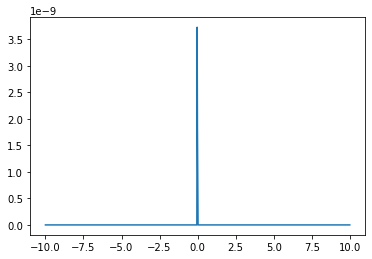

In [53]:
delta = 1.0e-9
width = 1.0e+1
a = torch.linspace(-width, +width, 1000)
b = torch.erf(a+delta) - torch.erf(a)
plt.plot(a, b)

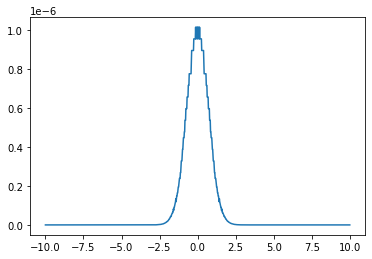

In [69]:
delta = 1.0e-6
width = 1.0e+1
a = torch.linspace(-width, +width, 1000)
b = torch.exp(-a**2+delta) - torch.exp(-a**2)
plt.plot(a, b)

In [62]:
b

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [29]:
from scipy.special import erf

# line width
δν = line.gaussian_width(model['temperature'], model['v_turbulence'])[0].item()

# Compute the prefactor
factor = constants.h.si.value * line.frequency / (4.0 * np.pi)

# Compute the LTE level populations
pop = line.LTE_pops(model['temperature'])

# Compute the emissivity and opacity
chi  = factor * (line.Einstein_Ba * pop[line.lower] - line.Einstein_Bs * pop[line.upper])
chi *= model['nCO']
chi  = chi[0].item()

In [30]:
abs_rel_diff = lambda a,b: np.abs(2.0*(a-b)/(a+b))

The optical depth is given by,
\begin{equation}
\begin{split}
\tau(\nu)
\ &= \
\int_{0}^{\ell} \text{d} l \ \chi_{ij} \, \phi \big( (1+\Delta\beta l) \nu \big) \\
\ &= \
\frac{\chi_{ij}}{2 \nu \Delta \beta}
\left(
    \text{Erf}\left[ \frac{\left(1 + \Delta\beta \ell \right) \nu - \nu_{ij}}{\delta\nu_{ij}} \right]
    \ - \
    \text{Erf}\left[ \frac{\nu - \nu_{ij}}{\delta\nu_{ij}} \right]
\right) .
\end{split}
\end{equation}

In [31]:
# Analytic solution
ν     = freqs
fac   = 1.0 + model['velocity_z'] / constants.c.si.value
fac_ν = torch.einsum("i, f -> if",  fac, ν)

τ = constants.c.si.value * chi/(2.0*ν*cΔβ) * (erf((fac_ν-line.frequency)/δν) - erf((ν-line.frequency)/δν) )

In [32]:
def plot2(i):
    fig, ax = plt.subplots(2,1, dpi=250)
    ax[0].plot(tau_old[i,:])
    ax[0].plot(tau_new[i,:])
    ax[0].plot(      τ[i,:])
    ax[1].plot(abs_rel_diff(tau_old[i,:], τ[i,:]))
    ax[1].plot(abs_rel_diff(tau_new[i,:], τ[i,:]))
    ax[1].set_yscale('log')
    plt.show()

interact(plot2, i=(0,N-1))

interactive(children=(IntSlider(value=63, description='i', max=127), Output()), _dom_classes=('widget-interact…

<function __main__.plot2(i)>